In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker
from matplotlib import colormaps
from matplotlib.colors import Normalize

import numpy as np
import os, glob
import time
import warnings

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=1
# from rur.sci.kinematics import f_getpot

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle
import argparse, subprocess
from importlib import reload
import cmasher as cmr
from copy import deepcopy
from multiprocessing import Pool, shared_memory

mode = 'nh'
iout = 1026
repo, rurmode, dp = mode2repo(mode)
snap = uri.RamsesSnapshot(repo, iout, mode=rurmode)
snaps = uri.TimeSeries(snap)
snaps.read_iout_avail()
nout = snaps.iout_avail['iout']
gals = uhmi.HaloMaker.load(snap, galaxy=True, double_precision=dp)
hals = uhmi.HaloMaker.load(snap, galaxy=False, double_precision=dp)
database = f"/home/jeon/MissingSat/database"

[Output 01026] Age (Gyr) : 11.624 / 13.741, z = 0.17149 (a = 0.8536)


In [2]:
LG = pklload(f"{database}/00_LocalGroup_final_h_addudg.pickle")

In [3]:
allsubs = None
for key in LG.keys():
    subs = LG[key]['subs']
    allsubs = subs if allsubs is None else np.hstack((allsubs, subs))
argsort = np.argsort(allsubs['id'])
allsubs = allsubs[argsort]
allsubs.dtype


dtype([('nparts', '<i4'), ('id', '<i4'), ('timestep', '<i4'), ('level', '<i4'), ('host', '<i4'), ('hostsub', '<i4'), ('nbsub', '<i4'), ('nextsub', '<i4'), ('aexp', '<f8'), ('m', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('vx', '<f8'), ('vy', '<f8'), ('vz', '<f8'), ('Lx', '<f8'), ('Ly', '<f8'), ('Lz', '<f8'), ('r', '<f8'), ('a', '<f8'), ('b', '<f8'), ('c', '<f8'), ('ek', '<f8'), ('ep', '<f8'), ('et', '<f8'), ('spin', '<f8'), ('sigma', '<f8'), ('rvir', '<f8'), ('mvir', '<f8'), ('tvir', '<f8'), ('cvel', '<f8'), ('rho0', '<f8'), ('rc', '<f8'), ('mcontam', '<f8'), ('r10_mem', '<f8'), ('r50_mem', '<f8'), ('r90_mem', '<f8'), ('r10_vir', '<f8'), ('r50_vir', '<f8'), ('r90_vir', '<f8'), ('r10_max', '<f8'), ('r50_max', '<f8'), ('r90_max', '<f8'), ('sub', '<i8'), ('dink', '?'), ('mdm', '<f8'), ('mstar', '<f8'), ('mcold', '<f8'), ('mcell', '<f8'), ('Host', '<i4'), ('r200kpc', '<f8'), ('m200', '<f8'), ('r200', '<f8')])

In [4]:
lastids = {}
maxid = 0
for sub in tqdm( allsubs ):
    lastids[sub['id']] = uhmi.HaloMaker.read_member_part(snaps.get_snap(sub['timestep']), sub['id'], galaxy=False, simple=True)
    maxid = max(maxid, lastids[sub['id']].max())
maxid

100%|██████████| 3851/3851 [00:01<00:00, 2421.18it/s]


125047740

In [30]:
iouts = os.listdir("/storage6/NewHorizon/halo")
iouts = [int(f[-5:]) for f in iouts if f.startswith("tree_bricks")]
iouts.sort()
iouts = np.array(iouts[::-1])

In [31]:
dtype = [("lastid", np.int16), ("timestep", np.int16), ("id", np.int16), ("give_score", np.float64), ("take_score", np.float64)]
nstep = len(iouts)
nsub = len(allsubs)

result = np.zeros(nstep*nsub, dtype=dtype)
result[:nsub]['lastid'] = allsubs['id']
result[:nsub]['timestep'] = allsubs['timestep']
result[:nsub]['id'] = allsubs['id']
result[:nsub]['give_score'] = 1
result[:nsub]['take_score'] = 1

cursor = nsub

In [36]:
for pout in tqdm(iouts[1:]):
    psnap = snaps.get_snap(pout)
    phals, ppids = uhmi.HaloMaker.load(psnap, galaxy=False, load_parts=True)
    cparts = phals['nparts']; cparts = np.cumsum(cparts); cparts = np.hstack((0, cparts))
    table = np.repeat(phals['id'], phals['nparts']).astype(np.int16)
    pids = np.zeros(max(maxid, ppids.max()), dtype=np.int32)
    pids[ppids-1] = table

    result[cursor:cursor+nsub]['lastid'] = allsubs['id']
    result[cursor:cursor+nsub]['timestep'] = pout

    for key in lastids.keys():
        pid = lastids[key]

        # Find Prog
        progs = pids[pid-1]
        unique, counts = np.unique(progs, return_counts=True)
        if( (len(unique)==1)&(0 in unique) ):
            prog=0
            give_score=0
            take_score=0
        else:
            if(0 in unique):
                mask = unique!=0
                unique = unique[mask]; counts = counts[mask]
            
            # Give Score
            argmax = np.argmax(counts)
            prog = unique[argmax]
            give_score = counts[argmax] / len(pid)
            # print(prog, give_score)

            # Take Score
            part_of_prog = ppids[ cparts[prog-1]:cparts[prog] ]
            ind = isin(part_of_prog, pid, assume_unique=True)
            take_score = np.sum(ind)/len(part_of_prog)
        result[cursor]['id'] = prog
        result[cursor]['give_score'] = give_score
        result[cursor]['take_score'] = take_score
        cursor += 1
    psnap.clear()
    del snaps.snaps[pout]
pklsave(result, f"{database}/02_main_progenitors.pickle")

100%|██████████| 3851/3851 [00:01<00:00, 3788.52it/s]


[Output 01024] Age (Gyr) : 11.612 / 13.741, z = 0.17261 (a = 0.8528)


100%|██████████| 3851/3851 [00:01<00:00, 2772.49it/s]


[Output 01023] Age (Gyr) : 11.608 / 13.741, z = 0.17293 (a = 0.8526)


KeyboardInterrupt: 

In [16]:
tarr = [0,0,0]
for key in tqdm( lastids.keys() ):
    pid = lastids[key]

    # Find Prog
    progs = pids[pid-1]
    unique, counts = np.unique(progs, return_counts=True)
    if( (len(unique)==1)&(0 in unique) ):
        prog=0
        give_score=0
        take_score=0
    else:
        if(0 in unique):
            mask = unique!=0
            unique = unique[mask]; counts = counts[mask]
        
        # Give Score
        argmax = np.argmax(counts)
        prog = unique[argmax]
        give_score = counts[argmax] / len(pid)
        # print(prog, give_score)

        # Take Score
        part_of_prog = ppids[ cparts[prog-1]:cparts[prog] ]
        ind = isin(part_of_prog, pid, assume_unique=True)
        take_score = np.sum(ind)/len(part_of_prog)

100%|██████████| 3851/3851 [00:01<00:00, 2602.86it/s]


In [23]:
key, prog, unique, counts, len(pid)

(24939, 24924, array([24924], dtype=int32), array([178]), 178)

In [19]:
take_score, give_score

(1.0, 1.0)

In [9]:
table.shape, ppids.shape

((63576592,), (63576592,))

In [24]:
allsubs['sub']

array([0, 0, 0, ..., 0, 0, 0])

In [7]:
len(allsubs), len(np.unique(allsubs['id']))

(3851, 3851)

In [15]:
ptree_dm = pklload("/storage6/NewHorizon/ptree_dm/ptree_stable.pkl")
np.max(ptree_dm['hmid'])

31929

In [16]:
np.int16(31929)

31929

In [14]:
ptree_dm.dtype

dtype([('nparts', '<i4'), ('timestep', '<i4'), ('level', '<i4'), ('host', '<i4'), ('hostsub', '<i4'), ('nbsub', '<i4'), ('nextsub', '<i4'), ('aexp', '<f4'), ('m', '<f4'), ('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('vx', '<f4'), ('vy', '<f4'), ('vz', '<f4'), ('Lx', '<f4'), ('Ly', '<f4'), ('Lz', '<f4'), ('r', '<f4'), ('a', '<f4'), ('b', '<f4'), ('c', '<f4'), ('ek', '<f4'), ('ep', '<f4'), ('et', '<f4'), ('spin', '<f4'), ('sigma', '<f4'), ('rvir', '<f4'), ('mvir', '<f4'), ('tvir', '<f4'), ('cvel', '<f4'), ('rho0', '<f4'), ('rc', '<f4'), ('npass', '<i4', (3, 4)), ('hmid', '<i4'), ('id', '<i8'), ('desc', '<i8', (3, 4)), ('fat', '<i8'), ('son', '<i8'), ('score_fat', '<f8'), ('score_son', '<f8'), ('nprog', '<i8'), ('ndesc', '<i8'), ('first', '<i8'), ('last', '<i8'), ('first_rev', '<i8'), ('last_rev', '<i8')])

In [10]:

tmp

(173, 1026, 1, 3797, 0, 0, -1, 0.8536139, 2.2580139e+08, 0.46665937, 0.47781152, 0.5196389, 87.81165, 148.05669, 45.939163, -22001868., -28816116., 16329762., 0.00023365, 0.00961726, 0.00533737, 0.00715285, 29.632973, -0.10264013, 29.530333, 20.736216, 82.52841, 9.651364e-05, 1.2530019e+08, 1653.2484, 6.786124, 62.217022, 9.651364e-05, [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]], 3797, 11636873, [[-1, -1, -1, -1], [-1, -1, -1, -1], [-1, -1, -1, -1]], 235823877, -1, 0.46531792, 0., 0, 1, 242010087, 11636873, -1, -1)

25258
11 11


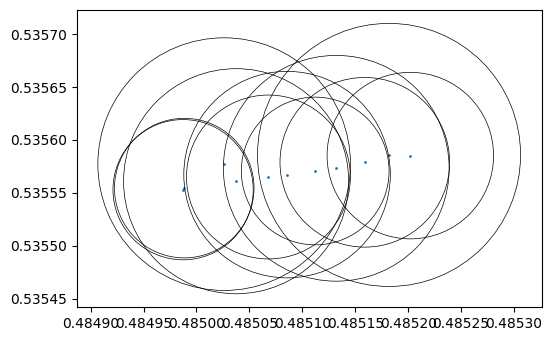

In [32]:
target = np.random.choice(allsubs)
tmp = ptree_dm[ (ptree_dm['hmid']==target['id'])&(ptree_dm['timestep']==target['timestep']) ][0]
print(tmp['hmid'])

samelast = ptree_dm[ptree_dm['last'] == tmp['last']]
argsort = np.argsort(samelast['timestep'])
samelast = samelast[argsort]
fig, ax = plt.subplots(figsize=(6,6))#, sharex=True, sharey=True)
ax.scatter(samelast['x'], samelast['y'], s=1)
for ihal in samelast:
    cir = circle(ihal, color='k', rname='rvir')
    ax.add_patch(cir)
ax.set_aspect(1)
print( len(samelast), len(np.unique(samelast['timestep'])) )

# samelast = ptree_dm[ptree_dm['first'] == tmp['first']]
# ax = axes[1]
# ax.scatter(samelast['x'], samelast['y'], s=1)
# for ihal in samelast:
#     cir = circle(ihal, color='k', rname='rvir')
#     ax.add_patch(cir)
# ax.set_aspect(1)
# print( len(samelast), len(np.unique(samelast['timestep'])) )

In [33]:
samelast[:5]['timestep']

array([1016, 1017, 1018, 1019, 1020], dtype=int32)

In [38]:
def printdt(table):
    for iname in table.dtype.names:
        print(f"{iname:10s} {table[iname]}")

In [39]:
printdt(samelast[0])

nparts     131
timestep   1016
level      4
host       5542
hostsub    25250
nbsub      0
nextsub    25251
aexp       0.8491386771202087
m          170982560.0
x          0.4852020740509033
y          0.5355851054191589
z          0.5239984393119812
vx         -262.8435974121094
vy         -35.21074676513672
vz         101.21028900146484
Lx         1061022.125
Ly         14673754.0
Lz         -7540389.0
r          9.0245739556849e-05
a          0.0016344417817890644
b          0.004110465291887522
c          0.003328179009258747
ek         31.094209671020508
ep         -0.13570444285869598
et         30.958505630493164
spin       17.69141960144043
sigma      115.32636260986328
rvir       7.866149098845199e-05
mvir       170982560.0
tvir       2782.57958984375
cvel       8.803929328918457
rho0       159.3079833984375
rc         7.866149098845199e-05
npass      [[115   8   8   0]
 [ 96  19  15   1]
 [ 92  38   1   0]]
hmid       25286
id         345936039
desc       [[345936038 345857132

In [43]:
aa = ptree_dm[ptree_dm['id'] == 346725595][0]
printdt(aa)

nparts     464
timestep   1015
level      3
host       5545
hostsub    25309
nbsub      0
nextsub    25318
aexp       0.8485590815544128
m          605617600.0
x          0.4853149950504303
y          0.5356280207633972
z          0.5240876078605652
vx         -99.36996459960938
vy         40.65567398071289
vz         101.90373229980469
Lx         -152222960.0
Ly         376112992.0
Lz         -2776298.25
r          0.00023595840320922434
a          0.003452897537499666
b          0.0026019508950412273
c          0.009360698983073235
ek         101.83783721923828
ep         -1.7786390781402588
et         100.05919647216797
spin       33.06216049194336
sigma      125.5080795288086
rvir       0.00016354965919163078
mvir       604312384.0
tvir       4733.3251953125
cvel       11.482486724853516
rho0       62.773223876953125
rc         0.00016354965919163078
npass      [[309 100  33  22]
 [285 102  62  15]
 [287  88  63  26]]
hmid       25317
id         346725595
desc       [[344989761 345

In [41]:
ptree_dm['id'].min()

106

In [35]:
samelast[0], ptree_dm.dtype

((131, 1016, 4, 5542, 25250, 0, 25251, 0.8491387, 1.7098256e+08, 0.48520207, 0.5355851, 0.52399844, -262.8436, -35.210747, 101.21029, 1061022.1, 14673754., -7540389., 9.024574e-05, 0.00163444, 0.00411047, 0.00332818, 31.09421, -0.13570444, 30.958506, 17.69142, 115.32636, 7.866149e-05, 1.7098256e+08, 2782.5796, 8.803929, 159.30798, 7.866149e-05, [[115,   8,   8,   0], [ 96,  19,  15,   1], [ 92,  38,   1,   0]], 25286, 345936039, [[345936038, 345857132,  21479717,        -1], [346804597,  21538747, 346541282, 346672927], [346225435,  21551875, 346093875,        -1]], 346725595, 345936038, 0.08225849, 0.21298354, 1, 0, 345936039, 345462728, -1, -1),
 dtype([('nparts', '<i4'), ('timestep', '<i4'), ('level', '<i4'), ('host', '<i4'), ('hostsub', '<i4'), ('nbsub', '<i4'), ('nextsub', '<i4'), ('aexp', '<f4'), ('m', '<f4'), ('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('vx', '<f4'), ('vy', '<f4'), ('vz', '<f4'), ('Lx', '<f4'), ('Ly', '<f4'), ('Lz', '<f4'), ('r', '<f4'), ('a', '<f4'), ('b', '<f4')